In [8]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Define a function to add Gaussian noise to images
def add_gaussian_noise(img, mean=0., std=0.1):
    noise = torch.randn(img.size()) * std + mean
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)  # Make sure pixel values remain between 0 and 1

# Define the transformations: convert to tensor and add noise
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_gaussian_noise(x))
])


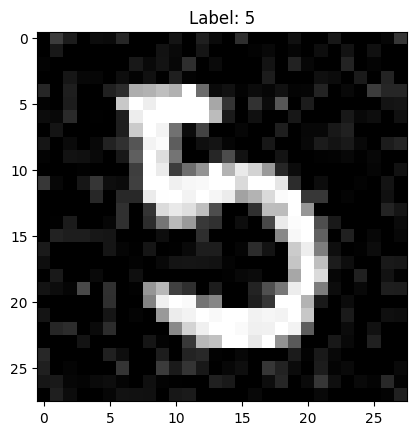

In [11]:
# Load the MNIST dataset with noise
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Check one example from the dataset
images, labels = next(iter(train_loader))
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.show()

In [12]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Log-variance
        
        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)  # Return mean and log-variance
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Return reparameterized latent vector

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))  # Sigmoid for pixel values between 0 and 1

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))  # Flatten input images
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [13]:
# Define the loss function for VAE
def vae_loss_function(recon_x, x, mu, logvar):
    # Binary Cross-Entropy for reconstruction loss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL Divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD


Epoch 1, Loss: 243.64355026041667
Epoch 2, Loss: 222.18100602213542
Epoch 3, Loss: 219.05739051920574
Epoch 4, Loss: 217.56913251139324
Epoch 5, Loss: 216.77252412923178
Epoch 6, Loss: 216.22463606770833
Epoch 7, Loss: 215.79799834798177
Epoch 8, Loss: 215.46280619303386
Epoch 9, Loss: 215.24330493164064
Epoch 10, Loss: 214.97974919433594
Epoch 11, Loss: 214.69868845214845
Epoch 12, Loss: 214.4912841064453
Epoch 13, Loss: 214.30266217447917
Epoch 14, Loss: 214.11275579427084
Epoch 15, Loss: 213.87935778808594
Epoch 16, Loss: 213.73531319986978
Epoch 17, Loss: 213.58643943684896
Epoch 18, Loss: 213.48198977864584
Epoch 19, Loss: 213.35981819661458
Epoch 20, Loss: 213.17200256347655
Epoch 21, Loss: 213.08784717610678
Epoch 22, Loss: 212.968291788737
Epoch 23, Loss: 212.8930309733073
Epoch 24, Loss: 212.7264719482422
Epoch 25, Loss: 212.67383002929688
Epoch 26, Loss: 212.58572079264323
Epoch 27, Loss: 212.47375693359376
Epoch 28, Loss: 212.38615319010415
Epoch 29, Loss: 212.3232538248698


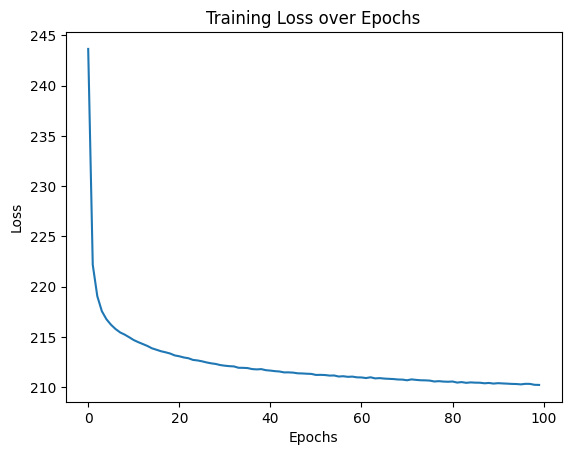

In [17]:
# Initialize the model, optimizer, and move model to device (GPU/CPU)
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop with 300 epochs and loss tracking
def train_and_plot(model, train_loader, optimizer, num_epochs=100):
    train_losses = []
    
    for epoch in range(1, num_epochs + 1):  # 100 epochs
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, logvar = model(data)

            # Compute loss and backpropagate
            loss = vae_loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        # Average loss per epoch
        avg_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch}, Loss: {avg_loss}')
    
    # Plotting the training loss over time
    plt.plot(train_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

# Train and plot loss for 300 epochs
train_and_plot(model, train_loader, optimizer, num_epochs=100)


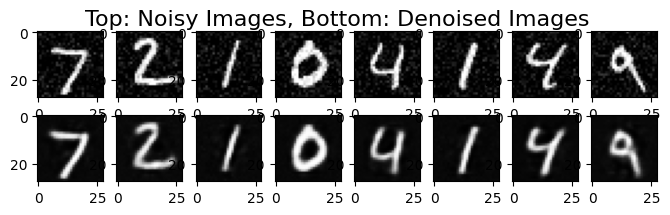

In [15]:
# Visualize the denoising results
def visualize_results(model, test_loader):
    model.eval()
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, _, _ = model(data)
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch.view(64, 1, 28, 28)[:n]])
                break
    
    comparison = comparison.cpu().numpy()
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(n, 2))
    
    # Top row: Noisy inputs, Bottom row: Denoised outputs
    fig.suptitle('Top: Noisy Images, Bottom: Denoised Images', fontsize=16)
    
    for j in range(n):
        axes[0, j].imshow(comparison[j][0], cmap='gray')
        axes[1, j].imshow(comparison[j + n][0], cmap='gray')

    plt.show()

# Visualize the results on the test dataset
visualize_results(model, test_loader)
